In [1]:
import ctypes
from plio.spatial import footprint
from plio.io.io_gdal import GeoDataset
import pyproj
import numpy as np
import ogr
from ctypes.util import find_library

import matplotlib.pyplot as plt

from csmapi import csmapi
import requests

lib = ctypes.CDLL(find_library('usgscsm'))

/home/jlaura/anaconda3/envs/ct/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import pvl
import json

In [402]:
prime = '/work/users/acpaquette/G03_019459_1800_XN_00N180W.IMG'
not_prime1 = '/work/users/acpaquette/G03_019458_2123_XN_32N157W.IMG'
not_prime2 = '/work/users/acpaquette/G03_019459_1443_XI_35S175W.IMG'
not_prime3= '/work/users/acpaquette/P04_002746_1808_XI_00N002W.IMG'

image = not_prime3

label = pvl.load(image)
data = {'label': pvl.dumps(label).decode()}

def get_model(image):
    label = pvl.load(image)
    data = {'label': pvl.dumps(label).decode()}
    
    isd = requests.post('http://pfeffer.wr.usgs.gov/v1/pds/', json=data).json()
    isd['IKCODE'] = -1
    isd = csmapi.Isd.loads(isd)
    plugin = csmapi.Plugin.findPlugin('USGS_ASTRO_LINE_SCANNER_PLUGIN')
    model_name = 'USGS_ASTRO_LINE_SCANNER_SENSOR_MODEL'
    
    if plugin.canModelBeConstructedFromISD(isd, model_name):
        model = plugin.constructModelFromISD(isd, model_name)
        
    return model

In [371]:
isd = requests.post('http://pfeffer.wr.usgs.gov/v1/pds/', json=data).json()

In [372]:
isd['IKCODE'] = -1

In [373]:
isd = csmapi.Isd.loads(isd)

In [374]:
plugin = csmapi.Plugin.findPlugin('USGS_ASTRO_LINE_SCANNER_PLUGIN')
print(plugin.canModelBeConstructedFromISD(isd, model_name))

True


In [375]:
model_name = 'USGS_ASTRO_LINE_SCANNER_SENSOR_MODEL'

In [376]:
if plugin.canModelBeConstructedFromISD(isd, model_name):
    model = plugin.constructModelFromISD(isd, model_name)

(0.0, 0.0)
(5056.0, 0.0)
(5056.0, 52224.0)
(0.0, 52224.0)
(0.0, 0.0)
(52224, 5056)


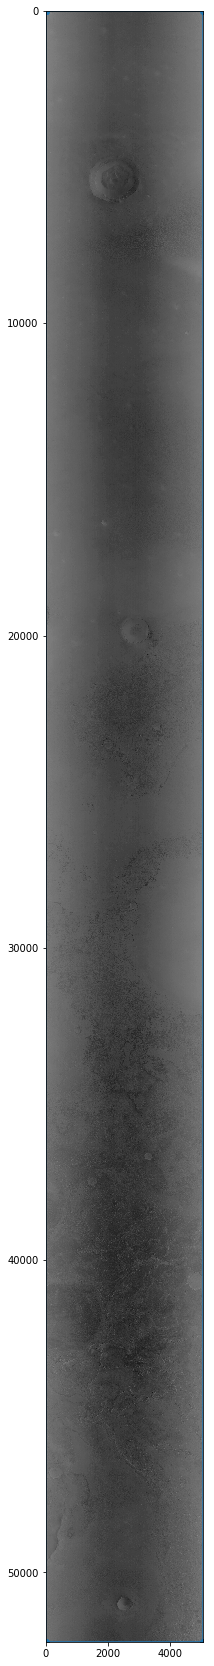

In [379]:
isize = model.getImageSize()

x = np.linspace(0,isize.samp, 2)
y = np.linspace(0,isize.line, 2)

boundary = [(i,0.) for i in x] + [(isize.samp, i) for i in y[1:]] +\
           [(i, isize.line) for i in x[::-1][1:]] + [(0.,i) for i in y[::-1][1:]]
    
x = []
y = []
    
for point in boundary:
    print(point)
    x.append(point[0])
    y.append(point[1])
plt.figure(figsize=(30, 30))
plt.plot(x, y, marker = "o")
geo_data = GeoDataset(image)
print(geo_data.read_array(1).shape)
plt.imshow((geo_data.read_array(1)), cmap = "Greys")
plt.show()

In [554]:
def generate_latlon_footprint(camera, nnodes=5, semi_major=3396190, semi_minor=3376200):
    ecef = pyproj.Proj(proj='geocent', a=semi_major, b=semi_minor)
    lla = pyproj.Proj(proj='latlon', a=semi_major, b=semi_minor)

    isize = camera.getImageSize()
    x = np.linspace(0,isize.samp, 10)
    y = np.linspace(0,isize.line, 10)
    boundary = [(i,0.) for i in x] + [(isize.samp, i) for i in y[1:]] +\
               [(i, isize.line) for i in x[::-1][1:]] + [(0.,i) for i in y[::-1][1:]]
    ring = ogr.Geometry(ogr.wkbLinearRing)
    wrap_ring = ogr.Geometry(ogr.wkbLinearRing)
    poly = ogr.Geometry(ogr.wkbPolygon)
    
    threshold_points = []
    ll_coords = []
    
    previous_point = None
    previous_dist = None
    reverse_seen = False
    
    for i in boundary:
        ipt = csmapi.ImageCoord(*i)
        gnd = camera.imageToGround(ipt, 0)
        lon, lat, alt = pyproj.transform(ecef, lla, gnd.x, gnd.y, gnd.z)
        
        if previous_point:
            if previous_point[0] > 0 and lon < 0 and not reverse_seen:
                threshold_points.append(previous_point)
                threshold_points.append([lon, lat])
            elif previous_point[0] < 0 and lon > 0 and len(threshold_points) != 0:
                threshold_points.append(previous_point)
                threshold_points.append([lon, lat])
            elif previous_point[0] < 0 and lon > 0:
                reverse_seen = True
                
        previous_point = [lon, lat]
        ll_coords.append([lon, lat])
    print(threshold_points)
    slope = ((threshold_points[1][1] - threshold_points[0][1]) / (threshold_points[1][0] - threshold_points[0][0]))
    b = slope*-(threshold_points[0][0]) + threshold_points[0][1]
    print(180 * slope + b)
    working_ring = ring
    
    for i in ll_coords:
        if i == threshold_points[1]:
            working_ring.AddPoint(180, 180 * slope + b)
            working_ring.AddPoint(180, threshold_points[2][1])
            working_ring = wrap_ring
        elif i == threshold_points[3]:
            working_ring.AddPoint(-180, threshold_points[3][1])
            working_ring.AddPoint(-180, -180 * slope + b)
            working_ring = ring
            
        working_ring.AddPoint(*i)
        
    
    poly.AddGeometry(ring)
    poly.AddGeometry(wrap_ring)
    return poly

In [555]:
model = get_model(prime)
fp = generate_latlon_footprint(model)

[[179.75920985348, -2.061130729244979], [-179.78850496176236, -2.0057227242469478], [-179.75786772188835, -2.2623073753220386], [179.79000697804474, -2.3176725103987255]]
-2.061167836146489


In [556]:
fp.GetGeometryRef(0).GetPoints()

[(-180.0, -2.3176725103987255, 0.0),
 (-180.0, -2.0056901318603106, 0.0),
 (179.79000697804474, -2.3176725103987255, 0.0),
 (179.78659244584165, -2.2890806994068593, 0.0),
 (179.7831697666408, -2.260583274072012, 0.0),
 (179.77974484174536, -2.232085070097688, 0.0),
 (179.77632562406987, -2.203595026124962, 0.0),
 (179.77290608558556, -2.1750937040225726, 0.0),
 (179.76947393355374, -2.1466078766501546, 0.0),
 (179.7660492372964, -2.118114872764363, 0.0),
 (179.76262221937642, -2.089620917350026, 0.0),
 (179.75920985348, -2.061130729244979, 0.0),
 (180.0, -2.061167836146489, 0.0),
 (180.0, -2.2623073753220386, 0.0),
 (179.79000697804474, -2.3176725103987255, 0.0)]

In [557]:
fp.GetGeometryRef(1).GetPoints()

[(-179.78850496176236, -2.0057227242469478, 0.0),
 (-179.33557798164517, -1.9501150394943698, 0.0),
 (-178.88087175924574, -1.8941706346474967, 0.0),
 (-178.42321861903912, -1.837747643077707, 0.0),
 (-177.96139988547736, -1.7806968435604333, 0.0),
 (-177.49412273666522, -1.722858807263428, 0.0),
 (-177.0199934585631, -1.6640605677793996, 0.0),
 (-176.53748552590005, -1.604111616553163, 0.0),
 (-176.04490039788016, -1.5427989568071736, 0.0),
 (-176.0416941983367, -1.5712593732402511, 0.0),
 (-176.0384564924871, -1.5997443601415462, 0.0),
 (-176.03522183143545, -1.628229343055586, 0.0),
 (-176.03197105162886, -1.6567060251021104, 0.0),
 (-176.02874583419722, -1.6851908389209838, 0.0),
 (-176.02552049326727, -1.7136512072120396, 0.0),
 (-176.02228377716486, -1.7421204403757695, 0.0),
 (-176.0190495445563, -1.7705933561675569, 0.0),
 (-176.01584282233694, -1.799135260494008, 0.0),
 (-176.5081865230387, -1.8605411865774504, 0.0),
 (-176.99046959467125, -1.9205639171050173, 0.0),
 (-177.464

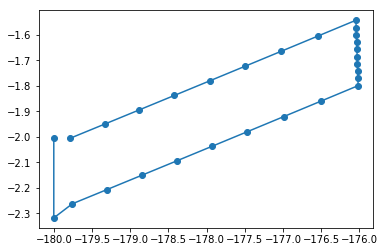

In [558]:
latlon_coords = fp.GetGeometryRef(1).GetPoints()

x = []
y = []

for point in latlon_coords:
    x.append(point[0])
    y.append(point[1])
plt.plot(x, y, marker = "o")

plt.show()

In [142]:
thing = model.getImageSize()
print(thing.line, thing.samp)

2048.0 2528.0


In [ ]:
dir(model)

In [ ]:
ipt = csmapi.ImageCoord(0,0)
ecef = model.imageToGround(ipt, 0)
ecef.x, ecef.y, ecef.z

In [ ]:
ic = model.groundToImage(ecef)
ic.samp, ic.line  # 1/2 pixel off in line...